In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
QWEN plastic pyrolysis classification analysis script (seaborn visualization)
=============================================================================

Input: all_results.csv with columns:
    - source_file
    - abstract
    - pyrolysis_related
    - include_in_oil_db
    - reason
    - flags

Features:
- Summary stats for pyrolysis_related / include_in_oil_db
- Cross table of (pyrolysis_related, include_in_oil_db)
- Flag frequency analysis (overall / include_in_oil_db=YES / include_in_oil_db=NO)
- Save summary tables as CSV
- Seaborn-based bar plots (clean, publication-style)
- tqdm + logging for progress and status
"""

import os
import logging
from collections import Counter

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# ============================================================
# Logging setup
# ============================================================
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)

# ============================================================
# Matplotlib + Seaborn style
# ============================================================
# Use default fonts; no explicit Korean font configuration
plt.rcParams["axes.unicode_minus"] = False

sns.set_theme(
    style="whitegrid",
    context="talk"
)


# ============================================================
# Flag parsing utility
# ============================================================
def parse_flags(series: pd.Series, desc: str = "Parsing flags") -> Counter:
    """
    Parse a flags column of the form 'A;B;C' into a Counter.

    - Ignores empty / NaN / whitespace-only entries.
    - Uses tqdm for progress visualization.
    """
    counter = Counter()
    for value in tqdm(series.fillna(""), desc=desc):
        text = str(value).strip()
        if not text:
            continue

        parts = text.split(";")
        for p in parts:
            flag = p.strip()
            if flag:
                counter[flag] += 1
    return counter


# ============================================================
# Bar plot utility (seaborn)
# ============================================================
def plot_bar(df_counts: pd.DataFrame,
             label_col: str,
             count_col: str,
             title: str,
             xlabel: str,
             ylabel: str,
             outpath: str,
             rotation: int = 45):
    """
    Create and save a bar plot using seaborn.

    - Slight transparency (alpha) and edgecolor for a clean, publication-style look.
    - Plots bars in the order of df_counts[label_col].
    """
    if df_counts.empty:
        logging.warning(f"[plot_bar] Empty DataFrame, skipping plot: {title}")
        return

    df_plot = df_counts.copy()
    df_plot[label_col] = df_plot[label_col].astype(str)

    plt.figure(figsize=(10, 6))

    ax = sns.barplot(
        data=df_plot,
        x=label_col,
        y=count_col,
        edgecolor="black",
        linewidth=1.0,
        alpha=0.8
    )

    ax.set_title(title, pad=15)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.xticks(rotation=rotation, ha="right")

    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.grid(axis="x", visible=False)

    plt.tight_layout()
    plt.savefig(outpath, dpi=180, transparent=False)
    plt.close()
    logging.info(f"Saved plot: {outpath}")


# ============================================================
# Main analysis function
# ============================================================
def analyze(csv_path: str = "all_results.csv",
            outdir: str = "analysis_results",
            top_n_flags: int = 20):
    """
    Run full analysis on QWEN classification results.

    Parameters
    ----------
    csv_path : str
        Path to all_results.csv.
    outdir : str
        Output directory for CSVs and figures.
    top_n_flags : int
        Number of top flags to visualize in bar plots.
    """
    os.makedirs(outdir, exist_ok=True)
    logging.info(f"Loading CSV: {csv_path}")
    df = pd.read_csv(csv_path)

    # 0. Basic column checks
    required_cols = [
        "source_file",
        "abstract",
        "pyrolysis_related",
        "include_in_oil_db",
        "reason",
        "flags"
    ]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # ----------------------------------------
    # 1. Basic stats for pyrolysis_related / include_in_oil_db
    # ----------------------------------------
    total = len(df)
    logging.info(f"Total samples: {total}")

    pyro_counts = df["pyrolysis_related"].value_counts(dropna=False)
    include_counts = df["include_in_oil_db"].value_counts(dropna=False)

    logging.info("pyrolysis_related distribution:")
    for k, v in pyro_counts.items():
        logging.info(f"  {k}: {v} ({v/total:.3%})")

    logging.info("include_in_oil_db distribution:")
    for k, v in include_counts.items():
        logging.info(f"  {k}: {v} ({v/total:.3%})")

    # Cross table
    combo = (
        df.groupby(["pyrolysis_related", "include_in_oil_db"])
        .size()
        .reset_index(name="count")
    )
    combo["ratio"] = combo["count"] / total

    combo_csv = os.path.join(outdir, "summary_combo_pyro_vs_include.csv")
    combo.to_csv(combo_csv, index=False, encoding="utf-8-sig")
    logging.info(f"Saved cross summary CSV: {combo_csv}")

    # Bar plot: pyrolysis_related
    pyro_df = pyro_counts.reset_index()
    pyro_df.columns = ["pyrolysis_related", "count"]
    plot_bar(
        pyro_df,
        label_col="pyrolysis_related",
        count_col="count",
        title="Distribution of pyrolysis_related",
        xlabel="pyrolysis_related",
        ylabel="Count",
        outpath=os.path.join(outdir, "pyrolysis_related_counts.png"),
        rotation=0,
    )

    # Bar plot: include_in_oil_db
    include_df = include_counts.reset_index()
    include_df.columns = ["include_in_oil_db", "count"]
    plot_bar(
        include_df,
        label_col="include_in_oil_db",
        count_col="count",
        title="Distribution of include_in_oil_db",
        xlabel="include_in_oil_db",
        ylabel="Count",
        outpath=os.path.join(outdir, "include_in_oil_db_counts.png"),
        rotation=0,
    )

    # ----------------------------------------
    # 2. Flag analysis (overall / include YES / include NO)
    # ----------------------------------------
    logging.info("Computing overall flag frequencies...")
    flags_all = parse_flags(df["flags"], desc="Parsing flags (all)")
    df_flags_all = pd.DataFrame(
        [{"flag": k, "count": v} for k, v in flags_all.most_common()]
    )
    flags_all_csv = os.path.join(outdir, "flags_counts_all.csv")
    df_flags_all.to_csv(flags_all_csv, index=False, encoding="utf-8-sig")
    logging.info(f"Saved overall flag counts CSV: {flags_all_csv}")

    # Subsets by include_in_oil_db
    df_yes = df[df["include_in_oil_db"] == "YES"]
    df_no = df[df["include_in_oil_db"] == "NO"]

    logging.info(f"Samples with include_in_oil_db=YES: {len(df_yes)}")
    logging.info(f"Samples with include_in_oil_db=NO : {len(df_no)}")

    flags_yes = parse_flags(df_yes["flags"], desc="Parsing flags (include_in_oil_db=YES)")
    flags_no = parse_flags(df_no["flags"], desc="Parsing flags (include_in_oil_db=NO)")

    df_flags_yes = pd.DataFrame(
        [{"flag": k, "count": v} for k, v in flags_yes.most_common()]
    )
    df_flags_no = pd.DataFrame(
        [{"flag": k, "count": v} for k, v in flags_no.most_common()]
    )

    flags_yes_csv = os.path.join(outdir, "flags_counts_include_yes.csv")
    flags_no_csv = os.path.join(outdir, "flags_counts_include_no.csv")
    df_flags_yes.to_csv(flags_yes_csv, index=False, encoding="utf-8-sig")
    df_flags_no.to_csv(flags_no_csv, index=False, encoding="utf-8-sig")
    logging.info(f"Saved flag counts CSV (include=YES): {flags_yes_csv}")
    logging.info(f"Saved flag counts CSV (include=NO) : {flags_no_csv}")

    # Top N flags for plotting
    top_all = df_flags_all.head(top_n_flags)
    top_yes = df_flags_yes.head(top_n_flags)
    top_no = df_flags_no.head(top_n_flags)

    plot_bar(
        top_all,
        label_col="flag",
        count_col="count",
        title=f"Top {top_n_flags} flags (all samples)",
        xlabel="Flag",
        ylabel="Frequency",
        outpath=os.path.join(outdir, f"flags_all_top{top_n_flags}.png"),
    )

    plot_bar(
        top_yes,
        label_col="flag",
        count_col="count",
        title=f"Top {top_n_flags} flags (include_in_oil_db=YES)",
        xlabel="Flag",
        ylabel="Frequency",
        outpath=os.path.join(outdir, f"flags_include_yes_top{top_n_flags}.png"),
    )

    plot_bar(
        top_no,
        label_col="flag",
        count_col="count",
        title=f"Top {top_n_flags} flags (include_in_oil_db=NO)",
        xlabel="Flag",
        ylabel="Frequency",
        outpath=os.path.join(outdir, f"flags_include_no_top{top_n_flags}.png"),
    )

    logging.info("=== Analysis completed ===")
    logging.info(f"Output directory: {os.path.abspath(outdir)}")


# ------------------------------------------------------------------
# Direct script execution (no argparse; edit arguments here if needed)
# ------------------------------------------------------------------

analyze(
    csv_path="all_results.csv",
    outdir="analysis_results",
    top_n_flags=20
)


2025-12-02 15:57:05,519 | INFO | Loading CSV: all_results.csv
2025-12-02 15:57:05,582 | INFO | Total samples: 1662
2025-12-02 15:57:05,583 | INFO | pyrolysis_related distribution:
2025-12-02 15:57:05,583 | INFO |   YES: 1522 (91.576%)
2025-12-02 15:57:05,584 | INFO |   NO: 140 (8.424%)
2025-12-02 15:57:05,584 | INFO | include_in_oil_db distribution:
2025-12-02 15:57:05,585 | INFO |   NO: 1342 (80.746%)
2025-12-02 15:57:05,586 | INFO |   YES: 320 (19.254%)
2025-12-02 15:57:05,591 | INFO | Saved cross summary CSV: analysis_results\summary_combo_pyro_vs_include.csv
2025-12-02 15:57:05,779 | INFO | Saved plot: analysis_results\pyrolysis_related_counts.png
2025-12-02 15:57:05,963 | INFO | Saved plot: analysis_results\include_in_oil_db_counts.png
2025-12-02 15:57:05,963 | INFO | Computing overall flag frequencies...
Parsing flags (all): 100%|██████████| 1662/1662 [00:00<00:00, 831060.23it/s]
2025-12-02 15:57:05,970 | INFO | Saved overall flag counts CSV: analysis_results\flags_counts_all.csv

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotlib_venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45437 sha256=0ca05201da3462d16ed839ddff24f58083bdb48a6040f72b1ed1d6a72f03afd7
  Stored in directory: c:\users\psid_pc_20\appdata\local\pip\cache\wheels\51\7e\04\79020d177ea85e21043f09b451e3a7d093f919ac874cadd4b2
Successfully built matplotlib_venn


2025-12-02 17:15:23,268 | INFO | === QWEN flag overlap analysis started ===
2025-12-02 17:15:23,268 | INFO | === QWEN flag overlap analysis started ===
2025-12-02 17:15:23,450 | INFO | Loaded CSV with 1662 rows from all_results.csv
2025-12-02 17:15:23,450 | INFO | Loaded CSV with 1662 rows from all_results.csv
Parsing flags: 100%|██████████| 1662/1662 [00:00<00:00, 207734.10it/s]
2025-12-02 17:15:23,480 | INFO | Parsed flags into list form (flags_list).
2025-12-02 17:15:23,480 | INFO | Parsed flags into list form (flags_list).
Counting global flag frequencies: 100%|██████████| 1662/1662 [00:00<00:00, 287094.16it/s]
2025-12-02 17:15:23,500 | INFO | Computed global flag counts.
2025-12-02 17:15:23,500 | INFO | Computed global flag counts.


,flag,count
0,NO_OIL_INFO,803
1,OIL_NOT_MAIN_PRODUCT,597
2,CO_PYROLYSIS,540
3,HAS_OIL_YIELD_DATA,325
4,HAS_OIL_COMPOSITION,311
5,TARGET_HYDROGEN,310
6,SINGLE_PLASTIC,275
7,GENERAL_CATALYST,263
8,TARGET_AROMATICS,241
9,CATALYST_MECHANISM_FOCUS,136


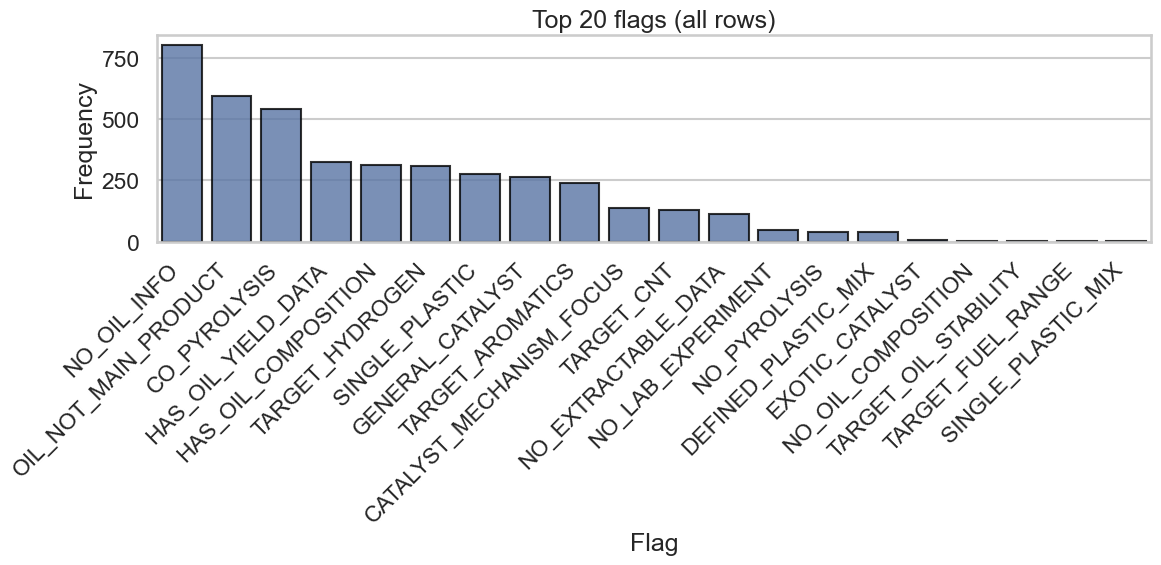

2025-12-02 17:15:24,014 | INFO | Computing pairwise co-occurrence for top 15 flags.
2025-12-02 17:15:24,014 | INFO | Computing pairwise co-occurrence for top 15 flags.
Parsing flags: 100%|██████████| 1662/1662 [00:00<00:00, 415307.31it/s]


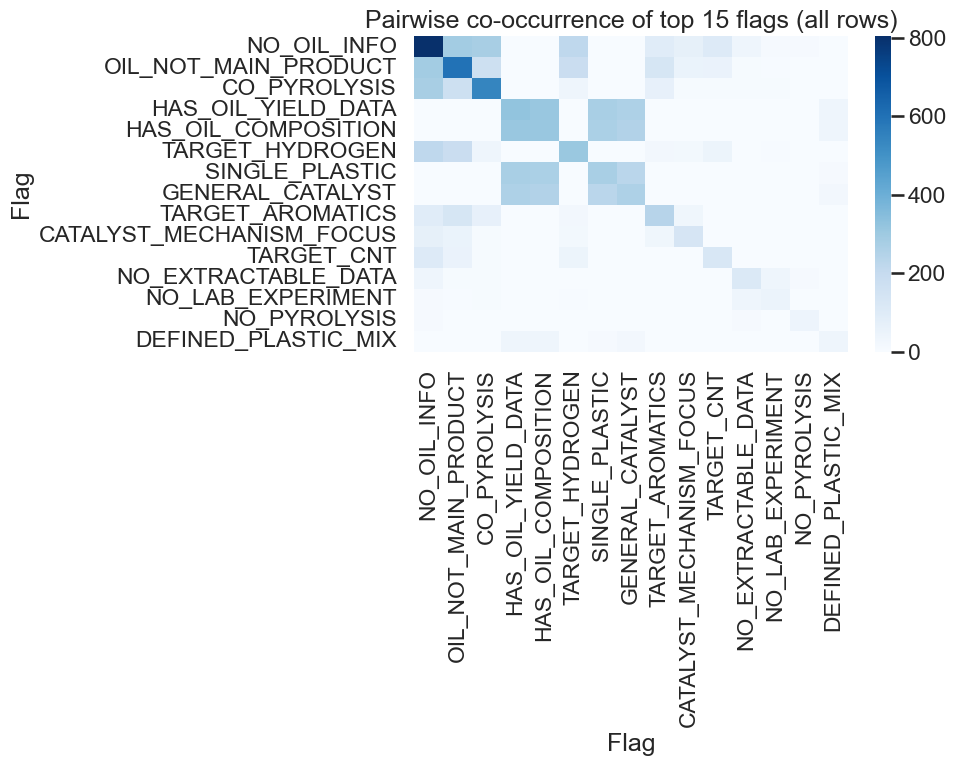

2025-12-02 17:15:24,609 | WARNING | upsetplot is not installed; skipping UpSet plot section.
2025-12-02 17:15:24,609 | WARNING | upsetplot is not installed; skipping UpSet plot section.
2025-12-02 17:15:24,615 | INFO | Rows with include_in_oil_db=NO: 1342
2025-12-02 17:15:24,615 | INFO | Rows with include_in_oil_db=NO: 1342
2025-12-02 17:15:24,619 | INFO | [NO only] NO_OIL_INFO: 803 rows
2025-12-02 17:15:24,619 | INFO | [NO only] NO_OIL_INFO: 803 rows
2025-12-02 17:15:24,621 | INFO | [NO only] OIL_NOT_MAIN_PRODUCT: 597 rows
2025-12-02 17:15:24,621 | INFO | [NO only] OIL_NOT_MAIN_PRODUCT: 597 rows
2025-12-02 17:15:24,622 | INFO | [NO only] CO_PYROLYSIS: 540 rows
2025-12-02 17:15:24,622 | INFO | [NO only] CO_PYROLYSIS: 540 rows
2025-12-02 17:15:24,627 | INFO | 3-flag Venn counts (include_in_oil_db=NO): {'A_only': 274, 'B_only': 174, 'C_only': 131, 'A&B_only': 252, 'A&C_only': 238, 'B&C_only': 132, 'A&B&C': 39}
2025-12-02 17:15:24,627 | INFO | 3-flag Venn counts (include_in_oil_db=NO): {'

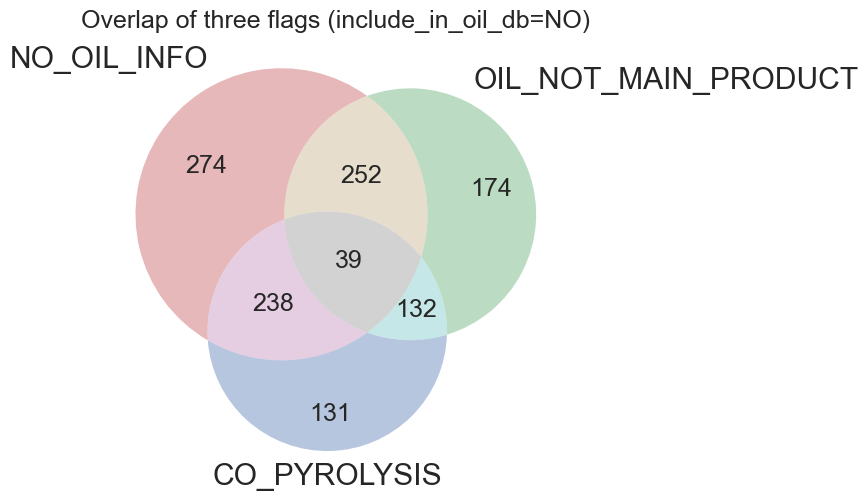

2025-12-02 17:15:24,742 | INFO | 2-flag Venn counts (include_in_oil_db=NO): {'NO_OIL_INFO only': 512, 'OIL_NOT_MAIN_PRODUCT only': 306, 'Both': 291}
2025-12-02 17:15:24,742 | INFO | 2-flag Venn counts (include_in_oil_db=NO): {'NO_OIL_INFO only': 512, 'OIL_NOT_MAIN_PRODUCT only': 306, 'Both': 291}


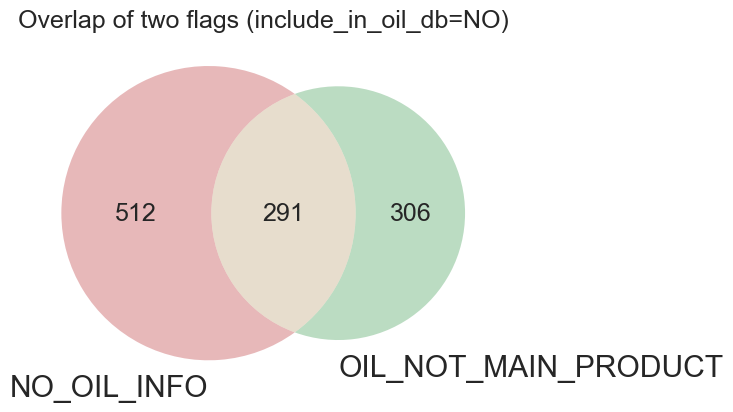

,subset,count
0,NO_OIL_INFO only,512
1,OIL_NOT_MAIN_PRODUCT only,306
2,Both,291


In [13]:
# %% [markdown]
# # QWEN Flag Overlap Analysis Notebook
#
# This notebook:
# 1. Loads `all_results.csv` (output of QWEN classifier).
# 2. Parses the `flags` column into a multi-label structure.
# 3. Provides:
#    - Global flag statistics and pairwise co-occurrence (heatmap, UpSet plot).
#    - Venn analysis for three flags among `include_in_oil_db=NO`:
#        * NO_OIL_INFO
#        * OIL_NOT_MAIN_PRODUCT
#        * CO_PYROLYSIS
#    - Venn analysis for two flags among `include_in_oil_db=NO`:
#        * NO_OIL_INFO
#        * OIL_NOT_MAIN_PRODUCT
#
# Logging + tqdm are used for progress and traceability.

# %%
import os
import logging
from collections import Counter
from itertools import combinations

import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

# UpSet can be optional
try:
    from upsetplot import UpSet, from_memberships
    HAS_UPSETPLOT = True
except ImportError:
    HAS_UPSETPLOT = False

# %% [markdown]
# ## Setup logging

# %%
os.makedirs("logs", exist_ok=True)
log_path = os.path.join("logs", "qwen_flag_overlap_analysis.log")

logger = logging.getLogger("qwen_flag_analysis")
logger.setLevel(logging.INFO)
logger.handlers.clear()

fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(fmt)
logger.addHandler(ch)

fh = logging.FileHandler(log_path, mode="a", encoding="utf-8")
fh.setLevel(logging.INFO)
fh.setFormatter(fmt)
logger.addHandler(fh)

logger.info("=== QWEN flag overlap analysis started ===")

# %% [markdown]
# ## Load `all_results.csv` and parse flags

# %%
CSV_PATH = "all_results.csv"

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"{CSV_PATH} not found in current directory.")

df = pd.read_csv(CSV_PATH)
logger.info(f"Loaded CSV with {len(df)} rows from {CSV_PATH}")

required_cols = [
    "source_file",
    "abstract",
    "pyrolysis_related",
    "include_in_oil_db",
    "reason",
    "flags",
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in all_results.csv: {missing}")

# tqdm integration with pandas
tqdm.pandas(desc="Parsing flags")

# Parse flags into list
df["flags"] = df["flags"].fillna("").astype(str)
df["flags_list"] = df["flags"].progress_apply(
    lambda x: [f.strip() for f in x.split(";") if f.strip()]
)

logger.info("Parsed flags into list form (flags_list).")

# %% [markdown]
# ## 1. Global flag statistics & co-occurrence

# %%
# Count each flag occurrence (at least once per row)
flag_counter = Counter()
for flist in tqdm(df["flags_list"], desc="Counting global flag frequencies"):
    for f in set(flist):  # use set to avoid double count in same row
        flag_counter[f] += 1

flag_counts_df = (
    pd.DataFrame(
        [{"flag": flag, "count": cnt} for flag, cnt in flag_counter.most_common()]
    )
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

logger.info("Computed global flag counts.")
display(flag_counts_df.head(20))

# %%
# Plot top N flags as barplot
TOP_N = 20
top_flags_df = flag_counts_df.head(TOP_N)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_flags_df, x="flag", y="count", edgecolor="black", alpha=0.8)
plt.title(f"Top {TOP_N} flags (all rows)")
plt.xlabel("Flag")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# %% [markdown]
# ### Pairwise co-occurrence (heatmap) for top K flags

# %%
TOP_K_FOR_COOC = 15   # you can adjust
top_k_flags = flag_counts_df["flag"].head(TOP_K_FOR_COOC).tolist()
logger.info(f"Computing pairwise co-occurrence for top {TOP_K_FOR_COOC} flags.")

# Build boolean matrix for these flags
for f in top_k_flags:
    col_name = f"has_{f}"
    df[col_name] = df["flags_list"].progress_apply(lambda flist, f=f: f in flist)

# Co-occurrence matrix
cooc_matrix = np.zeros((len(top_k_flags), len(top_k_flags)), dtype=int)

for i, f1 in enumerate(top_k_flags):
    mask1 = df[f"has_{f1}"]
    for j, f2 in enumerate(top_k_flags):
        mask2 = df[f"has_{f2}"]
        cooc_matrix[i, j] = int((mask1 & mask2).sum())

cooc_df = pd.DataFrame(
    cooc_matrix, index=top_k_flags, columns=top_k_flags
)

plt.figure(figsize=(10, 8))
sns.heatmap(cooc_df, annot=False, cmap="Blues")
plt.title(f"Pairwise co-occurrence of top {TOP_K_FOR_COOC} flags (all rows)")
plt.xlabel("Flag")
plt.ylabel("Flag")
plt.tight_layout()
plt.show()

# %% [markdown]
# ### UpSet plot (optional, if `upsetplot` is installed)
#
# This shows intersection sizes of the most frequent flag combinations
# across all flags.

# %%
if HAS_UPSETPLOT:
    logger.info("Creating UpSet plot for global flag combinations.")
    # Represent each row as a membership tuple (flags in that row)
    memberships = df["flags_list"].tolist()
    # Convert to UpSet input
    upset_data = from_memberships(memberships)
    # Limit to top intersections to keep plot readable
    plt.figure(figsize=(10, 6))
    UpSet(upset_data, subset_size="count", show_counts=True).plot()
    plt.suptitle("UpSet plot of flag combinations (all rows)")
    plt.show()
else:
    logger.warning("upsetplot is not installed; skipping UpSet plot section.")

# %% [markdown]
# ## 2. Focus on three flags (include_in_oil_db = NO)
#
# We now restrict to rows where `include_in_oil_db == 'NO'` and look at
# overlaps between:
# - NO_OIL_INFO
# - OIL_NOT_MAIN_PRODUCT
# - CO_PYROLYSIS

# %%
TARGET_FLAGS_3 = ["NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT", "CO_PYROLYSIS"]

df_no = df[df["include_in_oil_db"] == "NO"].copy()
logger.info(f"Rows with include_in_oil_db=NO: {len(df_no)}")

# Create boolean columns for each target flag
for f in TARGET_FLAGS_3:
    col_name = f"has_{f}"
    df_no[col_name] = df_no["flags_list"].apply(lambda flist, f=f: f in flist)

# Counts for single flags
for f in TARGET_FLAGS_3:
    col_name = f"has_{f}"
    cnt = int(df_no[col_name].sum())
    logger.info(f"[NO only] {f}: {cnt} rows")

# Compute triple intersection counts
A = df_no["has_NO_OIL_INFO"]
B = df_no["has_OIL_NOT_MAIN_PRODUCT"]
C = df_no["has_CO_PYROLYSIS"]

n100 = int((A & ~B & ~C).sum())
n010 = int((~A & B & ~C).sum())
n001 = int((~A & ~B & C).sum())
n110 = int((A & B & ~C).sum())
n101 = int((A & ~B & C).sum())
n011 = int((~A & B & C).sum())
n111 = int((A & B & C).sum())

venn_counts_3 = {
    "A_only": n100,
    "B_only": n010,
    "C_only": n001,
    "A&B_only": n110,
    "A&C_only": n101,
    "B&C_only": n011,
    "A&B&C": n111,
}

logger.info(f"3-flag Venn counts (include_in_oil_db=NO): {venn_counts_3}")
venn_counts_3

# %%
# Plot Venn diagram for 3 sets
plt.figure(figsize=(6, 6))
v = venn3(
    subsets=(n100, n010, n110, n001, n101, n011, n111),
    set_labels=("NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT", "CO_PYROLYSIS"),
)
plt.title("Overlap of three flags (include_in_oil_db=NO)")
plt.show()

# %%
# Also create a small summary table for the three flags
rows_3 = []
rows_3.append(["NO_OIL_INFO only", n100])
rows_3.append(["OIL_NOT_MAIN_PRODUCT only", n010])
rows_3.append(["CO_PYROLYSIS only", n001])
rows_3.append(["NO_OIL_INFO + OIL_NOT_MAIN_PRODUCT only", n110])
rows_3.append(["NO_OIL_INFO + CO_PYROLYSIS only", n101])
rows_3.append(["OIL_NOT_MAIN_PRODUCT + CO_PYROLYSIS only", n011])
rows_3.append(["All three", n111])

summary_3_df = pd.DataFrame(rows_3, columns=["subset", "count"])
summary_3_df

# %% [markdown]
# ## 3. Focus on two flags (include_in_oil_db = NO)
#
# Now we restrict to the same `include_in_oil_db=NO` subset and
# only look at overlaps between:
# - NO_OIL_INFO
# - OIL_NOT_MAIN_PRODUCT

# %%
TARGET_FLAGS_2 = ["NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT"]

# Boolean columns (already created above, but recreate to be safe)
for f in TARGET_FLAGS_2:
    col_name = f"has_{f}"
    df_no[col_name] = df_no["flags_list"].apply(lambda flist, f=f: f in flist)

A2 = df_no["has_NO_OIL_INFO"]
B2 = df_no["has_OIL_NOT_MAIN_PRODUCT"]

n10 = int((A2 & ~B2).sum())  # only A
n01 = int((~A2 & B2).sum())  # only B
n11 = int((A2 & B2).sum())   # both

venn_counts_2 = {
    "NO_OIL_INFO only": n10,
    "OIL_NOT_MAIN_PRODUCT only": n01,
    "Both": n11,
}
logger.info(f"2-flag Venn counts (include_in_oil_db=NO): {venn_counts_2}")
venn_counts_2

# %%
# Plot Venn diagram for 2 sets
plt.figure(figsize=(6, 6))
v2 = venn2(
    subsets=(n10, n01, n11),
    set_labels=("NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT"),
)
plt.title("Overlap of two flags (include_in_oil_db=NO)")
plt.show()

# %%
# Summary table for two-flag overlaps
summary_2_df = pd.DataFrame(
    [
        ["NO_OIL_INFO only", n10],
        ["OIL_NOT_MAIN_PRODUCT only", n01],
        ["Both", n11],
    ],
    columns=["subset", "count"],
)
summary_2_df

# %% [markdown]
# ---
# ## Done
#
# - Global flag frequency + co-occurrence (heatmap, optional UpSet).
# - 3-flag Venn for `NO_OIL_INFO`, `OIL_NOT_MAIN_PRODUCT`, `CO_PYROLYSIS`
#   on `include_in_oil_db=NO` rows.
# - 2-flag Venn for `NO_OIL_INFO`, `OIL_NOT_MAIN_PRODUCT`
#   on `include_in_oil_db=NO` rows.
#
# You can now:
# - Export `summary_3_df` / `summary_2_df` to CSV if needed.
# - Adjust `TARGET_FLAGS_3` / `TARGET_FLAGS_2` or filter conditions
#   to explore other combinations.


2025-12-02 17:20:17,647 | INFO | === QWEN flag overlap analysis (include_in_oil_db=NO only) started ===
2025-12-02 17:20:17,647 | INFO | === QWEN flag overlap analysis (include_in_oil_db=NO only) started ===
2025-12-02 17:20:18,008 | INFO | Loaded CSV with 1662 rows from all_results.csv
2025-12-02 17:20:18,008 | INFO | Loaded CSV with 1662 rows from all_results.csv
2025-12-02 17:20:18,012 | INFO | Filtered to include_in_oil_db=NO → 1342 rows remain.
2025-12-02 17:20:18,012 | INFO | Filtered to include_in_oil_db=NO → 1342 rows remain.
Parsing flags: 100%|██████████| 1342/1342 [00:00<00:00, 672170.52it/s]
2025-12-02 17:20:18,019 | INFO | Parsed flags into list form (flags_list) on NO-only subset.
2025-12-02 17:20:18,019 | INFO | Parsed flags into list form (flags_list) on NO-only subset.
Counting global flag frequencies (NO only): 100%|██████████| 1342/1342 [00:00<00:00, 670888.67it/s]
2025-12-02 17:20:18,025 | INFO | Computed global flag counts on NO-only subset.
2025-12-02 17:20:18,025

,flag,count
0,NO_OIL_INFO,803
1,OIL_NOT_MAIN_PRODUCT,597
2,CO_PYROLYSIS,540
3,TARGET_HYDROGEN,310
4,TARGET_AROMATICS,241
5,CATALYST_MECHANISM_FOCUS,136
6,TARGET_CNT,127
7,NO_EXTRACTABLE_DATA,113
8,NO_LAB_EXPERIMENT,49
9,NO_PYROLYSIS,41


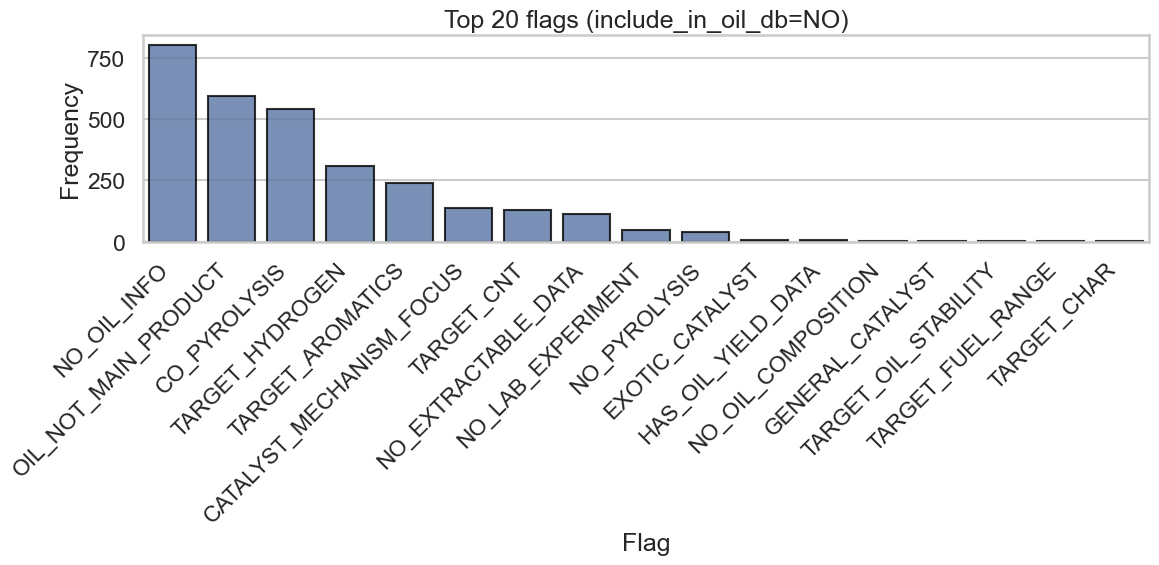

2025-12-02 17:20:18,284 | INFO | Computing pairwise co-occurrence for top 15 flags (NO only).
2025-12-02 17:20:18,284 | INFO | Computing pairwise co-occurrence for top 15 flags (NO only).
Parsing flags: 100%|██████████| 1342/1342 [00:00<00:00, 670648.87it/s]


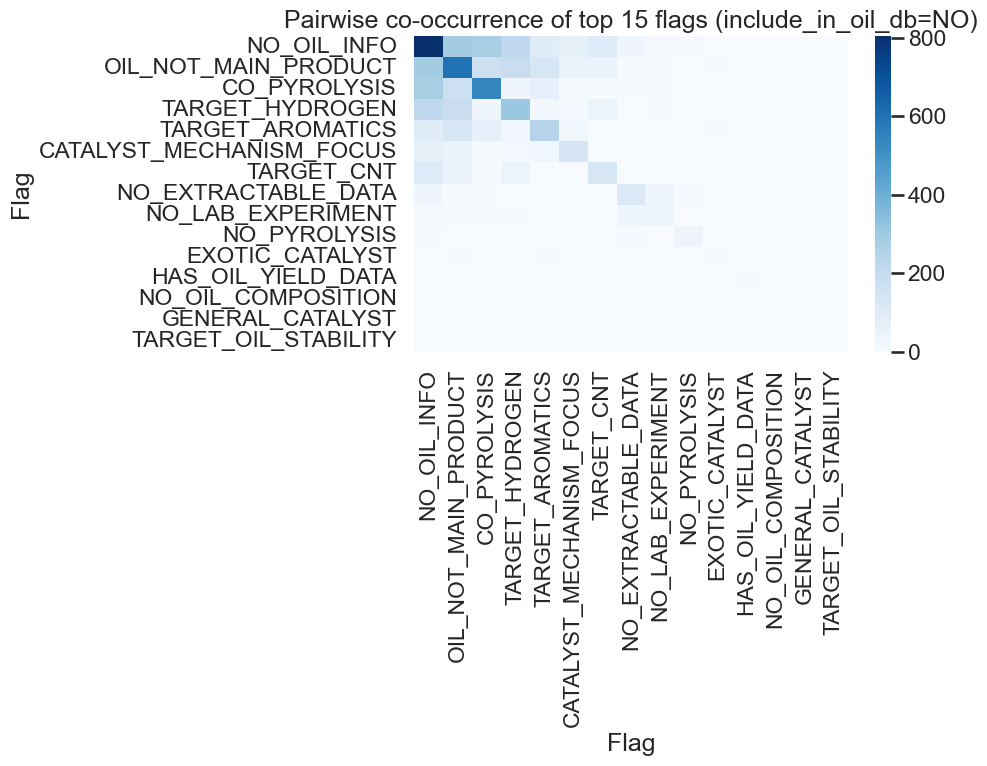

2025-12-02 17:20:19,010 | WARNING | upsetplot is not installed; skipping UpSet plot section.
2025-12-02 17:20:19,010 | WARNING | upsetplot is not installed; skipping UpSet plot section.
2025-12-02 17:20:19,013 | INFO | Rows in NO subset: 1342
2025-12-02 17:20:19,013 | INFO | Rows in NO subset: 1342
2025-12-02 17:20:19,019 | INFO | [NO subset] NO_OIL_INFO: 803 rows
2025-12-02 17:20:19,019 | INFO | [NO subset] NO_OIL_INFO: 803 rows
2025-12-02 17:20:19,020 | INFO | [NO subset] OIL_NOT_MAIN_PRODUCT: 597 rows
2025-12-02 17:20:19,020 | INFO | [NO subset] OIL_NOT_MAIN_PRODUCT: 597 rows
2025-12-02 17:20:19,021 | INFO | [NO subset] CO_PYROLYSIS: 540 rows
2025-12-02 17:20:19,021 | INFO | [NO subset] CO_PYROLYSIS: 540 rows
2025-12-02 17:20:19,026 | INFO | 3-flag Venn counts (NO subset): {'A_only': 274, 'B_only': 174, 'C_only': 131, 'A&B_only': 252, 'A&C_only': 238, 'B&C_only': 132, 'A&B&C': 39}
2025-12-02 17:20:19,026 | INFO | 3-flag Venn counts (NO subset): {'A_only': 274, 'B_only': 174, 'C_only

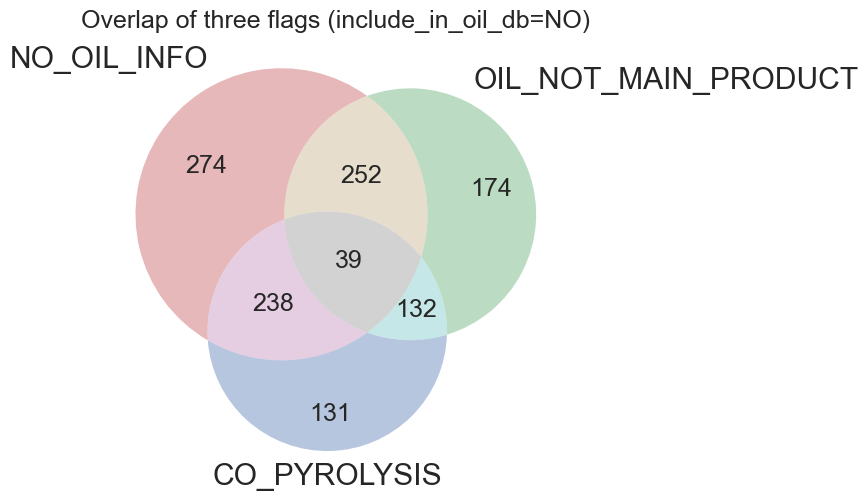

2025-12-02 17:20:19,125 | INFO | 2-flag Venn counts (NO subset): {'NO_OIL_INFO only': 512, 'OIL_NOT_MAIN_PRODUCT only': 306, 'Both': 291}
2025-12-02 17:20:19,125 | INFO | 2-flag Venn counts (NO subset): {'NO_OIL_INFO only': 512, 'OIL_NOT_MAIN_PRODUCT only': 306, 'Both': 291}


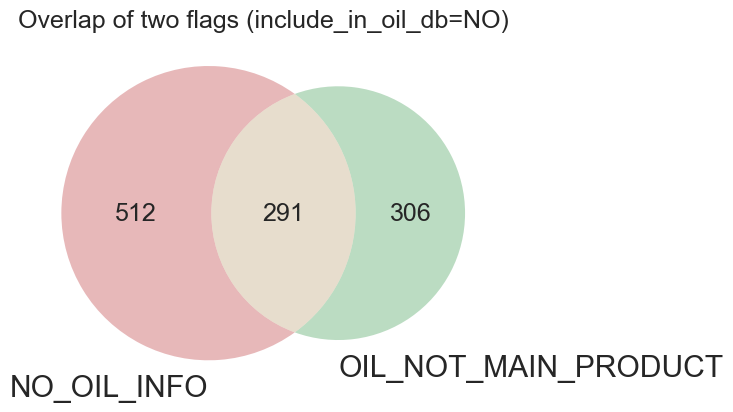

,subset,count
0,NO_OIL_INFO only,512
1,OIL_NOT_MAIN_PRODUCT only,306
2,Both,291


In [15]:
# %% [markdown]
# # QWEN Flag Overlap Analysis Notebook (ONLY include_in_oil_db=NO)
#
# This notebook:
# 1. Loads `all_results.csv` (output of QWEN classifier).
# 2. Filters rows to those with `include_in_oil_db == "NO"` (oil-DB exclusion set).
# 3. Parses the `flags` column into a multi-label structure.
# 4. Provides:
#    - Global flag statistics and pairwise co-occurrence (heatmap, UpSet plot) for NO rows.
#    - Venn analysis for three flags among the NO subset:
#        * NO_OIL_INFO
#        * OIL_NOT_MAIN_PRODUCT
#        * CO_PYROLYSIS
#    - Venn analysis for two flags among the NO subset:
#        * NO_OIL_INFO
#        * OIL_NOT_MAIN_PRODUCT
#
# Logging + tqdm are used for progress and traceability.

# %%
import os
import logging
from collections import Counter

import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

# UpSet can be optional
try:
    from upsetplot import UpSet, from_memberships
    HAS_UPSETPLOT = True
except ImportError:
    HAS_UPSETPLOT = False

# %% [markdown]
# ## Setup logging

# %%
os.makedirs("logs", exist_ok=True)
log_path = os.path.join("logs", "qwen_flag_overlap_analysis_NO_only.log")

logger = logging.getLogger("qwen_flag_analysis_no_only")
logger.setLevel(logging.INFO)
logger.handlers.clear()

fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(fmt)
logger.addHandler(ch)

fh = logging.FileHandler(log_path, mode="a", encoding="utf-8")
fh.setLevel(logging.INFO)
fh.setFormatter(fmt)
logger.addHandler(fh)

logger.info("=== QWEN flag overlap analysis (include_in_oil_db=NO only) started ===")

# %% [markdown]
# ## Load `all_results.csv`, filter to NO, and parse flags

# %%
CSV_PATH = "all_results.csv"

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"{CSV_PATH} not found in current directory.")

df_full = pd.read_csv(CSV_PATH)
logger.info(f"Loaded CSV with {len(df_full)} rows from {CSV_PATH}")

required_cols = [
    "source_file",
    "abstract",
    "pyrolysis_related",
    "include_in_oil_db",
    "reason",
    "flags",
]
missing = [c for c in required_cols if c not in df_full.columns]
if missing:
    raise ValueError(f"Missing required columns in all_results.csv: {missing}")

# Filter to rows with include_in_oil_db == "NO"
df = df_full[df_full["include_in_oil_db"] == "NO"].copy()
logger.info(f"Filtered to include_in_oil_db=NO → {len(df)} rows remain.")

# tqdm integration with pandas
tqdm.pandas(desc="Parsing flags")

# Parse flags into list
df["flags"] = df["flags"].fillna("").astype(str)
df["flags_list"] = df["flags"].progress_apply(
    lambda x: [f.strip() for f in x.split(";") if f.strip()]
)

logger.info("Parsed flags into list form (flags_list) on NO-only subset.")

# %% [markdown]
# ## 1. Global flag statistics & co-occurrence (NO subset)

# %%
# Count each flag occurrence (at least once per row)
flag_counter = Counter()
for flist in tqdm(df["flags_list"], desc="Counting global flag frequencies (NO only)"):
    for f in set(flist):  # avoid double count in same row
        flag_counter[f] += 1

flag_counts_df = (
    pd.DataFrame(
        [{"flag": flag, "count": cnt} for flag, cnt in flag_counter.most_common()]
    )
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

logger.info("Computed global flag counts on NO-only subset.")
display(flag_counts_df.head(20))

# %%
# Plot top N flags as barplot
TOP_N = 20
top_flags_df = flag_counts_df.head(TOP_N)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_flags_df, x="flag", y="count", edgecolor="black", alpha=0.8)
plt.title(f"Top {TOP_N} flags (include_in_oil_db=NO)")
plt.xlabel("Flag")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# %% [markdown]
# ### Pairwise co-occurrence (heatmap) for top K flags (NO subset)

# %%
TOP_K_FOR_COOC = 15   # you can adjust
top_k_flags = flag_counts_df["flag"].head(TOP_K_FOR_COOC).tolist()
logger.info(f"Computing pairwise co-occurrence for top {TOP_K_FOR_COOC} flags (NO only).")

# Build boolean matrix for these flags
for f in top_k_flags:
    col_name = f"has_{f}"
    df[col_name] = df["flags_list"].progress_apply(lambda flist, f=f: f in flist)

# Co-occurrence matrix
cooc_matrix = np.zeros((len(top_k_flags), len(top_k_flags)), dtype=int)

for i, f1 in enumerate(top_k_flags):
    mask1 = df[f"has_{f1}"]
    for j, f2 in enumerate(top_k_flags):
        mask2 = df[f"has_{f2}"]
        cooc_matrix[i, j] = int((mask1 & mask2).sum())

cooc_df = pd.DataFrame(
    cooc_matrix, index=top_k_flags, columns=top_k_flags
)

plt.figure(figsize=(10, 8))
sns.heatmap(cooc_df, annot=False, cmap="Blues")
plt.title(f"Pairwise co-occurrence of top {TOP_K_FOR_COOC} flags (include_in_oil_db=NO)")
plt.xlabel("Flag")
plt.ylabel("Flag")
plt.tight_layout()
plt.show()

# %% [markdown]
# ### UpSet plot (optional, NO subset)

# %%
if HAS_UPSETPLOT:
    logger.info("Creating UpSet plot for flag combinations (NO-only subset).")
    memberships = df["flags_list"].tolist()
    upset_data = from_memberships(memberships)
    plt.figure(figsize=(10, 6))
    UpSet(upset_data, subset_size="count", show_counts=True).plot()
    plt.suptitle("UpSet plot of flag combinations (include_in_oil_db=NO)")
    plt.show()
else:
    logger.warning("upsetplot is not installed; skipping UpSet plot section.")

# %% [markdown]
# ## 2. Focus on three flags within NO subset
#
# Overlaps between:
# - NO_OIL_INFO
# - OIL_NOT_MAIN_PRODUCT
# - CO_PYROLYSIS

# %%
TARGET_FLAGS_3 = ["NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT", "CO_PYROLYSIS"]

logger.info(f"Rows in NO subset: {len(df)}")

# Create boolean columns for each target flag
for f in TARGET_FLAGS_3:
    col_name = f"has_{f}"
    df[col_name] = df["flags_list"].apply(lambda flist, f=f: f in flist)

# Counts for single flags
for f in TARGET_FLAGS_3:
    col_name = f"has_{f}"
    cnt = int(df[col_name].sum())
    logger.info(f"[NO subset] {f}: {cnt} rows")

# Compute triple intersection counts
A = df["has_NO_OIL_INFO"]
B = df["has_OIL_NOT_MAIN_PRODUCT"]
C = df["has_CO_PYROLYSIS"]

n100 = int((A & ~B & ~C).sum())
n010 = int((~A & B & ~C).sum())
n001 = int((~A & ~B & C).sum())
n110 = int((A & B & ~C).sum())
n101 = int((A & ~B & C).sum())
n011 = int((~A & B & C).sum())
n111 = int((A & B & C).sum())

venn_counts_3 = {
    "A_only": n100,
    "B_only": n010,
    "C_only": n001,
    "A&B_only": n110,
    "A&C_only": n101,
    "B&C_only": n011,
    "A&B&C": n111,
}

logger.info(f"3-flag Venn counts (NO subset): {venn_counts_3}")
venn_counts_3

# %%
# Plot Venn diagram for 3 sets
plt.figure(figsize=(6, 6))
v = venn3(
    subsets=(n100, n010, n110, n001, n101, n011, n111),
    set_labels=("NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT", "CO_PYROLYSIS"),
)
plt.title("Overlap of three flags (include_in_oil_db=NO)")
plt.show()

# %%
# Summary table for the three flags
rows_3 = []
rows_3.append(["NO_OIL_INFO only", n100])
rows_3.append(["OIL_NOT_MAIN_PRODUCT only", n010])
rows_3.append(["CO_PYROLYSIS only", n001])
rows_3.append(["NO_OIL_INFO + OIL_NOT_MAIN_PRODUCT only", n110])
rows_3.append(["NO_OIL_INFO + CO_PYROLYSIS only", n101])
rows_3.append(["OIL_NOT_MAIN_PRODUCT + CO_PYROLYSIS only", n011])
rows_3.append(["All three", n111])

summary_3_df = pd.DataFrame(rows_3, columns=["subset", "count"])
summary_3_df

# %% [markdown]
# ## 3. Focus on two flags within NO subset
#
# Overlaps between:
# - NO_OIL_INFO
# - OIL_NOT_MAIN_PRODUCT

# %%
TARGET_FLAGS_2 = ["NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT"]

for f in TARGET_FLAGS_2:
    col_name = f"has_{f}"
    # Already present, but re-assign just to be explicit
    df[col_name] = df["flags_list"].apply(lambda flist, f=f: f in flist)

A2 = df["has_NO_OIL_INFO"]
B2 = df["has_OIL_NOT_MAIN_PRODUCT"]

n10 = int((A2 & ~B2).sum())  # only A
n01 = int((~A2 & B2).sum())  # only B
n11 = int((A2 & B2).sum())   # both

venn_counts_2 = {
    "NO_OIL_INFO only": n10,
    "OIL_NOT_MAIN_PRODUCT only": n01,
    "Both": n11,
}
logger.info(f"2-flag Venn counts (NO subset): {venn_counts_2}")
venn_counts_2

# %%
# Plot Venn diagram for 2 sets
plt.figure(figsize=(6, 6))
v2 = venn2(
    subsets=(n10, n01, n11),
    set_labels=("NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT"),
)
plt.title("Overlap of two flags (include_in_oil_db=NO)")
plt.show()

# %%
# Summary table for two-flag overlaps
summary_2_df = pd.DataFrame(
    [
        ["NO_OIL_INFO only", n10],
        ["OIL_NOT_MAIN_PRODUCT only", n01],
        ["Both", n11],
    ],
    columns=["subset", "count"],
)
summary_2_df

# %% [markdown]
# ---
# ## Done (NO-only analysis)
#
# - All statistics are now computed **only on rows with `include_in_oil_db == "NO"`**.
# - You can export `summary_3_df` / `summary_2_df` to CSV if desired:
#
# ```python
# summary_3_df.to_csv("venn_three_flags_NO_only.csv", index=False)
# summary_2_df.to_csv("venn_two_flags_NO_only.csv", index=False)
# ```
#
# If you want to repeat the same analysis for the YES subset,
# just change the initial filter from `"NO"` to `"YES"` and rerun.


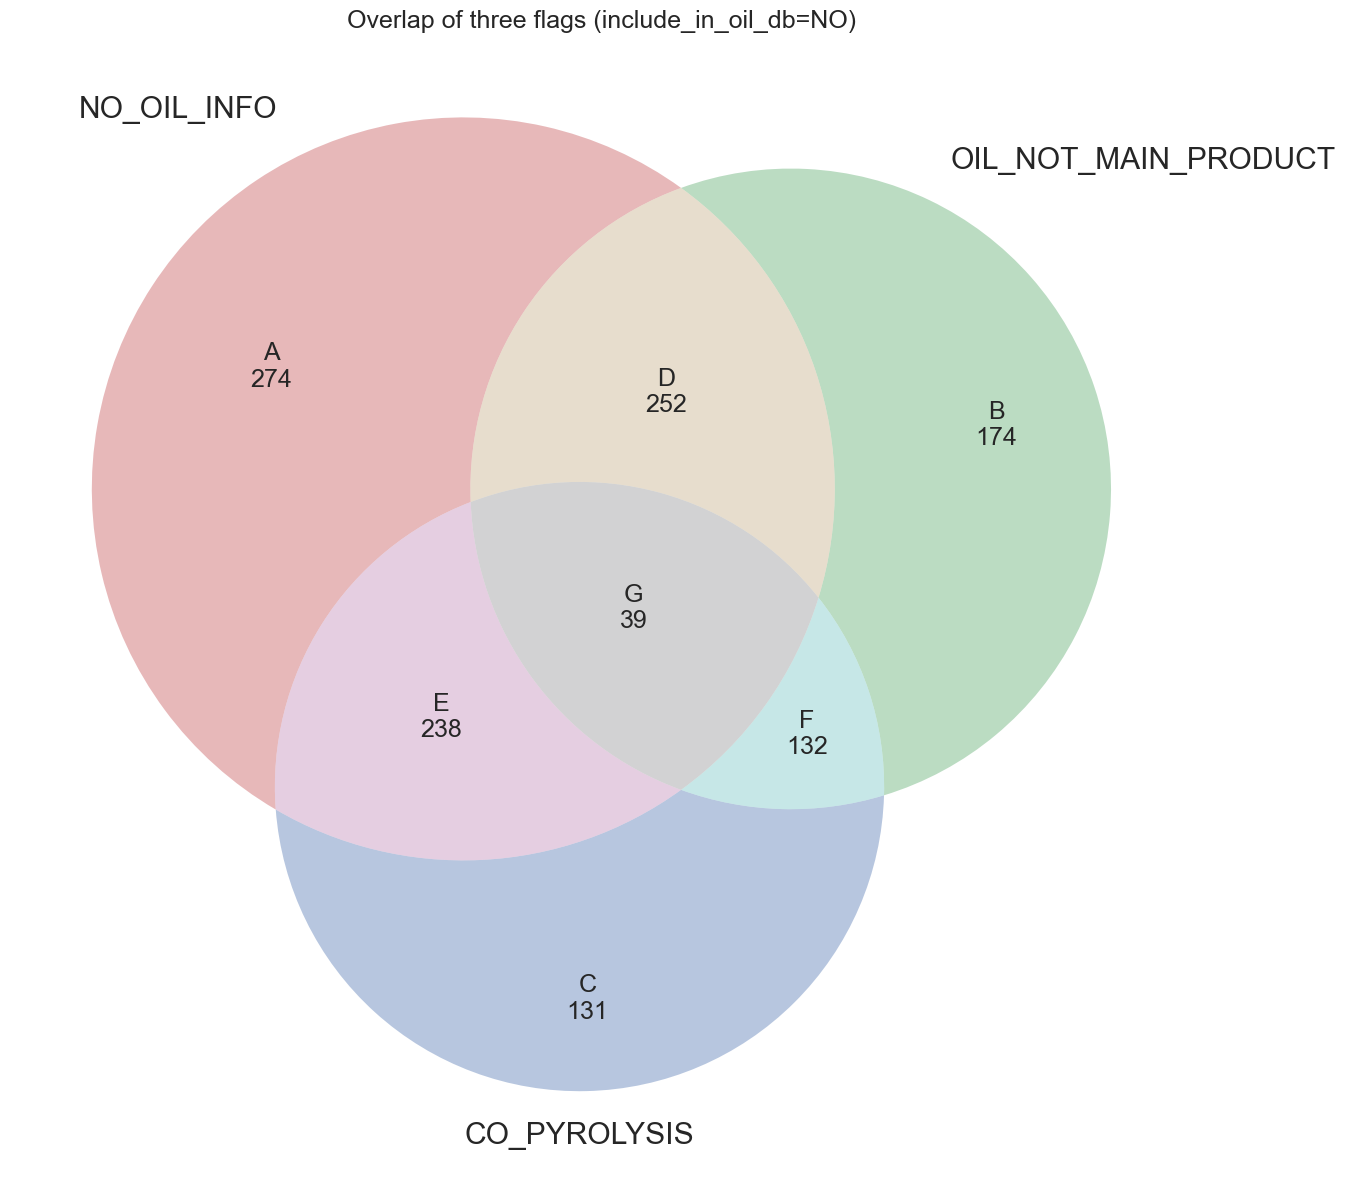

In [19]:
# --- 3-flag Venn diagram with group labels (A~G + counts) ---

plt.figure(figsize=(14, 25))
v = venn3(
    subsets=(n100, n010, n110, n001, n101, n011, n111),
    set_labels=("NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT", "CO_PYROLYSIS"),
)

# mapping: region ID -> (group label, count)
venn_labels = {
    "100": ("A", n100),   # NO_OIL_INFO only
    "010": ("B", n010),   # OIL_NOT_MAIN_PRODUCT only
    "001": ("C", n001),   # CO_PYROLYSIS only
    "110": ("D", n110),   # NO_OIL_INFO + OIL_NOT_MAIN_PRODUCT only
    "101": ("E", n101),   # NO_OIL_INFO + CO_PYROLYSIS only
    "011": ("F", n011),   # OIL_NOT_MAIN_PRODUCT + CO_PYROLYSIS only
    "111": ("G", n111),   # all three
}

for region_id, (g_label, cnt) in venn_labels.items():
    lbl = v.get_label_by_id(region_id)
    if lbl is not None:
        lbl.set_text(f"{g_label}\n{cnt}")  # group letter + count on next line

plt.title("Overlap of three flags (include_in_oil_db=NO)")
plt.tight_layout()
plt.show()


In [20]:
# --- Assign GROUP label to each row in NO subset ---

def assign_group(row):
    a = bool(row["has_NO_OIL_INFO"])
    b = bool(row["has_OIL_NOT_MAIN_PRODUCT"])
    c = bool(row["has_CO_PYROLYSIS"])

    pattern = (a, b, c)

    # mapping (A~G) + NONE(for no flag among the three)
    mapping = {
        (True,  False, False): "A",   # NO_OIL_INFO only
        (False, True,  False): "B",   # OIL_NOT_MAIN_PRODUCT only
        (False, False, True ): "C",   # CO_PYROLYSIS only
        (True,  True,  False): "D",   # NO_OIL_INFO + OIL_NOT_MAIN_PRODUCT only
        (True,  False, True ): "E",   # NO_OIL_INFO + CO_PYROLYSIS only
        (False, True,  True ): "F",   # OIL_NOT_MAIN_PRODUCT + CO_PYROLYSIS only
        (True,  True,  True ): "G",   # all three
        (False, False, False): "NONE",# has none of the three flags
    }
    return mapping.get(pattern, "NONE")

# add GROUP column
df["GROUP"] = df.apply(assign_group, axis=1)

# quick sanity check: counts per GROUP
group_counts = df["GROUP"].value_counts().sort_index()
logger.info("GROUP counts (NO subset):")
for g, cnt in group_counts.items():
    logger.info(f"  {g}: {cnt}")

display(group_counts)


2025-12-02 17:36:04,702 | INFO | GROUP counts (NO subset):
2025-12-02 17:36:04,702 | INFO | GROUP counts (NO subset):
2025-12-02 17:36:04,704 | INFO |   A: 274
2025-12-02 17:36:04,704 | INFO |   A: 274
2025-12-02 17:36:04,707 | INFO |   B: 174
2025-12-02 17:36:04,707 | INFO |   B: 174
2025-12-02 17:36:04,708 | INFO |   C: 131
2025-12-02 17:36:04,708 | INFO |   C: 131
2025-12-02 17:36:04,709 | INFO |   D: 252
2025-12-02 17:36:04,709 | INFO |   D: 252
2025-12-02 17:36:04,710 | INFO |   E: 238
2025-12-02 17:36:04,710 | INFO |   E: 238
2025-12-02 17:36:04,711 | INFO |   F: 132
2025-12-02 17:36:04,711 | INFO |   F: 132
2025-12-02 17:36:04,713 | INFO |   G: 39
2025-12-02 17:36:04,713 | INFO |   G: 39
2025-12-02 17:36:04,716 | INFO |   NONE: 102
2025-12-02 17:36:04,716 | INFO |   NONE: 102


GROUP
A       274
B       174
C       131
D       252
E       238
F       132
G        39
NONE    102
Name: count, dtype: int64

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Merge articles metadata with QWEN results, focus on include_in_oil_db=NO,
compute 3-flag Venn (NO_OIL_INFO, OIL_NOT_MAIN_PRODUCT, CO_PYROLYSIS),
assign GROUP labels (A~G/NONE) to each row, and save to CSV.
"""

import os
import logging

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# -------------------------------------------------
# Logging setup
# -------------------------------------------------
os.makedirs("logs", exist_ok=True)
log_path = os.path.join("logs", "no_subset_grouping.log")

logger = logging.getLogger("no_subset_grouping")
logger.setLevel(logging.INFO)
logger.handlers.clear()

fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(fmt)
logger.addHandler(ch)

fh = logging.FileHandler(log_path, mode="a", encoding="utf-8")
fh.setLevel(logging.INFO)
fh.setFormatter(fmt)
logger.addHandler(fh)

logger.info("=== Start: merge + NO subset + GROUP assignment ===")

# -------------------------------------------------
# 1) Load CSVs and inner-merge on source_file
# -------------------------------------------------
ARTICLES_CSV = "articles_V10_QWEN_input.csv"
RESULTS_CSV = "all_results.csv"

if not os.path.exists(ARTICLES_CSV):
    raise FileNotFoundError(f"{ARTICLES_CSV} not found")

if not os.path.exists(RESULTS_CSV):
    raise FileNotFoundError(f"{RESULTS_CSV} not found")

logger.info(f"Loading articles from {ARTICLES_CSV}")
df_articles = pd.read_csv(ARTICLES_CSV)

logger.info(f"Loading QWEN results from {RESULTS_CSV}")
df_results = pd.read_csv(RESULTS_CSV)

if "source_file" not in df_articles.columns or "source_file" not in df_results.columns:
    raise ValueError("Both CSVs must contain 'source_file' column for merge.")

logger.info("Performing inner merge on 'source_file' ...")
df_merged = pd.merge(df_articles, df_results, on="source_file", how="inner")
logger.info(f"Merged rows: {len(df_merged)}")

# -------------------------------------------------
# 2) Filter to include_in_oil_db == 'NO'
# -------------------------------------------------
df_merged["include_in_oil_db"] = df_merged["include_in_oil_db"].astype(str)
df_no = df_merged[df_merged["include_in_oil_db"] == "NO"].copy()
logger.info(f"Rows in NO subset after merge: {len(df_no)}")

# -------------------------------------------------
# 3) Parse flags into list
# -------------------------------------------------
tqdm.pandas(desc="Parsing flags")

df_no["flags"] = df_no["flags"].fillna("").astype(str)
df_no["flags_list"] = df_no["flags"].progress_apply(
    lambda x: [f.strip() for f in x.split(";") if f.strip()]
)

# -------------------------------------------------
# 4) Boolean columns for the three target flags
# -------------------------------------------------
TARGET_FLAGS_3 = ["NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT", "CO_PYROLYSIS"]

for f in TARGET_FLAGS_3:
    col = f"has_{f}"
    df_no[col] = df_no["flags_list"].apply(lambda flist, f=f: f in flist)
    logger.info(f"[NO subset] {f}: {int(df_no[col].sum())} rows")

# alias for brevity
A = df_no["has_NO_OIL_INFO"]
B = df_no["has_OIL_NOT_MAIN_PRODUCT"]
C = df_no["has_CO_PYROLYSIS"]

# region counts
n100 = int((A & ~B & ~C).sum())   # A only
n010 = int((~A & B & ~C).sum())   # B only
n001 = int((~A & ~B & C).sum())   # C only
n110 = int((A & B & ~C).sum())    # A & B only
n101 = int((A & ~B & C).sum())    # A & C only
n011 = int((~A & B & C).sum())


2025-12-02 17:36:10,067 | INFO | Saved NO subset with GROUP column to: d:\20251114_Pyrolysis_data_crawling\20251202_pyrolysis_data\try03_20251202\no_subset_with_groups.csv
2025-12-02 17:36:10,067 | INFO | Saved NO subset with GROUP column to: d:\20251114_Pyrolysis_data_crawling\20251202_pyrolysis_data\try03_20251202\no_subset_with_groups.csv


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Merge articles metadata with QWEN results, focus on include_in_oil_db=NO,
compute 3-flag Venn (NO_OIL_INFO, OIL_NOT_MAIN_PRODUCT, CO_PYROLYSIS),
assign GROUP labels (A~G/NONE) to each row, and save to CSV.
"""

import os
import logging

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# -------------------------------------------------
# Logging setup
# -------------------------------------------------
os.makedirs("logs", exist_ok=True)
log_path = os.path.join("logs", "no_subset_grouping.log")

logger = logging.getLogger("no_subset_grouping")
logger.setLevel(logging.INFO)
logger.handlers.clear()

fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(fmt)
logger.addHandler(ch)

fh = logging.FileHandler(log_path, mode="a", encoding="utf-8")
fh.setLevel(logging.INFO)
fh.setFormatter(fmt)
logger.addHandler(fh)

logger.info("=== Start: merge + NO subset + GROUP assignment ===")

# -------------------------------------------------
# 1) Load CSVs and inner-merge on source_file
# -------------------------------------------------
ARTICLES_CSV = "articles_V10_QWEN_input.csv"
RESULTS_CSV = "all_results.csv"

if not os.path.exists(ARTICLES_CSV):
    raise FileNotFoundError(f"{ARTICLES_CSV} not found")

if not os.path.exists(RESULTS_CSV):
    raise FileNotFoundError(f"{RESULTS_CSV} not found")

logger.info(f"Loading articles from {ARTICLES_CSV}")
df_articles = pd.read_csv(ARTICLES_CSV)

logger.info(f"Loading QWEN results from {RESULTS_CSV}")
df_results = pd.read_csv(RESULTS_CSV)

if "source_file" not in df_articles.columns or "source_file" not in df_results.columns:
    raise ValueError("Both CSVs must contain 'source_file' column for merge.")

logger.info("Performing inner merge on 'source_file' ...")
df_merged = pd.merge(df_articles, df_results, on="source_file", how="inner")
logger.info(f"Merged rows: {len(df_merged)}")

# -------------------------------------------------
# 2) Filter to include_in_oil_db == 'NO'
# -------------------------------------------------
df_merged["include_in_oil_db"] = df_merged["include_in_oil_db"].astype(str)
df_no = df_merged[df_merged["include_in_oil_db"] == "NO"].copy()
logger.info(f"Rows in NO subset after merge: {len(df_no)}")

# -------------------------------------------------
# 3) Parse flags into list
# -------------------------------------------------
tqdm.pandas(desc="Parsing flags")

df_no["flags"] = df_no["flags"].fillna("").astype(str)
df_no["flags_list"] = df_no["flags"].progress_apply(
    lambda x: [f.strip() for f in x.split(";") if f.strip()]
)

# -------------------------------------------------
# 4) Boolean columns for the three target flags
# -------------------------------------------------
TARGET_FLAGS_3 = ["NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT", "CO_PYROLYSIS"]

for f in TARGET_FLAGS_3:
    col = f"has_{f}"
    df_no[col] = df_no["flags_list"].apply(lambda flist, f=f: f in flist)
    logger.info(f"[NO subset] {f}: {int(df_no[col].sum())} rows")

# alias for brevity
A = df_no["has_NO_OIL_INFO"]
B = df_no["has_OIL_NOT_MAIN_PRODUCT"]
C = df_no["has_CO_PYROLYSIS"]

# region counts
n100 = int((A & ~B & ~C).sum())   # A only
n010 = int((~A & B & ~C).sum())   # B only
n001 = int((~A & ~B & C).sum())   # C only
n110 = int((A & B & ~C).sum())    # A & B only
n101 = int((A & ~B & C).sum())    # A & C only
n011 = int((~A & B & C).sum())    # B & C only
n111 = int((A & B & C).sum())     # A & B & C

venn_counts_3 = {
    "A_only": n100,
    "B_only": n010,
    "C_only": n001,
    "A&B_only": n110,
    "A&C_only": n101,
    "B&C_only": n011,
    "A&B&C": n111,
}
logger.info(f"3-flag Venn counts (NO subset): {venn_counts_3}")

# -------------------------------------------------
# 5) Plot Venn with group letters (A~G + counts)
# -------------------------------------------------
plt.figure(figsize=(6, 6))
v = venn3(
    subsets=(n100, n010, n110, n001, n101, n011, n111),
    set_labels=("NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT", "CO_PYROLYSIS"),
)

# mapping region -> (group label, count)
venn_labels = {
    "100": ("A", n100),
    "010": ("B", n010),
    "001": ("C", n001),
    "110": ("D", n110),
    "101": ("E", n101),
    "011": ("F", n011),
    "111": ("G", n111),
}

for region_id, (g_label, cnt) in venn_labels.items():
    lbl = v.get_label_by_id(region_id)
    if lbl is not None:
        lbl.set_text(f"{g_label}\n{cnt}")

plt.title("Overlap of NO_OIL_INFO / OIL_NOT_MAIN_PRODUCT / CO_PYROLYSIS (include_in_oil_db=NO)")
plt.tight_layout()
plt.savefig("venn_NO_subset_A_to_G.png", dpi=200)
plt.show()
logger.info("Saved Venn diagram: venn_NO_subset_A_to_G.png")

# -------------------------------------------------
# 6) Assign GROUP label per row (A~G or NONE)
# -------------------------------------------------
def assign_group(row):
    a = bool(row["has_NO_OIL_INFO"])
    b = bool(row["has_OIL_NOT_MAIN_PRODUCT"])
    c = bool(row["has_CO_PYROLYSIS"])

    pattern = (a, b, c)
    mapping = {
        (True,  False, False): "A",   # NO_OIL_INFO only
        (False, True,  False): "B",   # OIL_NOT_MAIN_PRODUCT only
        (False, False, True ): "C",   # CO_PYROLYSIS only
        (True,  True,  False): "D",   # A+B only
        (True,  False, True ): "E",   # A+C only
        (False, True,  True ): "F",   # B+C only
        (True,  True,  True ): "G",   # all three
        (False, False, False): "NONE"
    }
    return mapping.get(pattern, "NONE")

df_no["GROUP"] = df_no.apply(assign_group, axis=1)

group_counts = df_no["GROUP"].value_counts().sort_index()
logger.info("GROUP counts in NO subset:")
for g, cnt in group_counts.items():
    logger.info(f"  {g}: {cnt}")

# -------------------------------------------------
# 7) Save merged NO subset with GROUP column to CSV
# -------------------------------------------------
out_csv = "no_subset_with_groups.csv"
df_no.to_csv(out_csv, index=False, encoding="utf-8-sig")
logger.info(f"Saved NO subset with GROUP column to: {os.path.abspath(out_csv)}")
logger.info("=== Done ===")


2025-12-02 17:41:03,849 | INFO | === Start: merge + NO subset + GROUP assignment ===
2025-12-02 17:41:03,849 | INFO | === Start: merge + NO subset + GROUP assignment ===
2025-12-02 17:41:03,852 | INFO | Loading articles from articles_V10_QWEN_input.csv
2025-12-02 17:41:03,852 | INFO | Loading articles from articles_V10_QWEN_input.csv
2025-12-02 17:41:04,811 | INFO | Loading QWEN results from all_results.csv
2025-12-02 17:41:04,811 | INFO | Loading QWEN results from all_results.csv
2025-12-02 17:41:04,866 | INFO | Performing inner merge on 'source_file' ...
2025-12-02 17:41:04,866 | INFO | Performing inner merge on 'source_file' ...
2025-12-02 17:41:04,889 | INFO | Merged rows: 1662
2025-12-02 17:41:04,889 | INFO | Merged rows: 1662
2025-12-02 17:41:04,909 | INFO | Rows in NO subset after merge: 1342
2025-12-02 17:41:04,909 | INFO | Rows in NO subset after merge: 1342
Parsing flags: 100%|██████████| 1342/1342 [00:00<00:00, 223780.70it/s]
2025-12-02 17:41:04,925 | INFO | [NO subset] NO_O

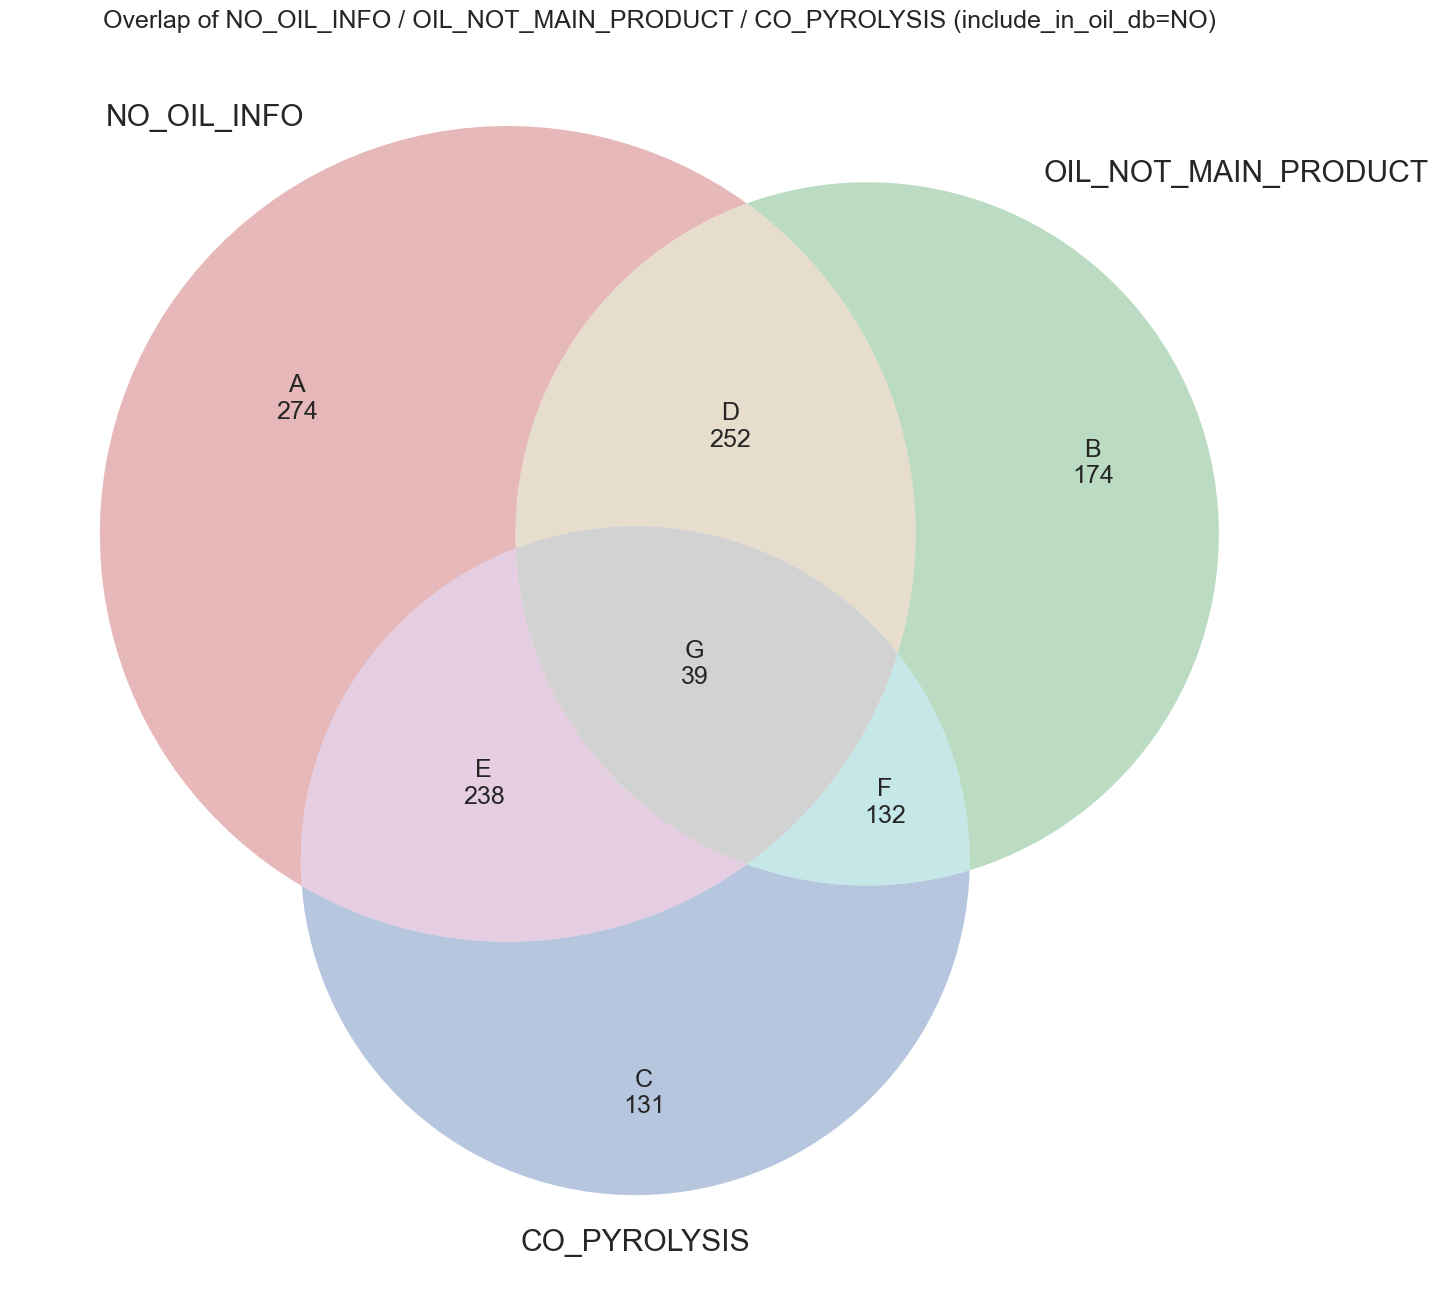

2025-12-02 17:41:05,550 | INFO | Saved Venn diagram: venn_NO_subset_A_to_G.png
2025-12-02 17:41:05,550 | INFO | Saved Venn diagram: venn_NO_subset_A_to_G.png
2025-12-02 17:41:05,576 | INFO | GROUP counts in NO subset:
2025-12-02 17:41:05,576 | INFO | GROUP counts in NO subset:
2025-12-02 17:41:05,578 | INFO |   A: 274
2025-12-02 17:41:05,578 | INFO |   A: 274
2025-12-02 17:41:05,579 | INFO |   B: 174
2025-12-02 17:41:05,579 | INFO |   B: 174
2025-12-02 17:41:05,581 | INFO |   C: 131
2025-12-02 17:41:05,581 | INFO |   C: 131
2025-12-02 17:41:05,582 | INFO |   D: 252
2025-12-02 17:41:05,582 | INFO |   D: 252
2025-12-02 17:41:05,583 | INFO |   E: 238
2025-12-02 17:41:05,583 | INFO |   E: 238
2025-12-02 17:41:05,586 | INFO |   F: 132
2025-12-02 17:41:05,586 | INFO |   F: 132
2025-12-02 17:41:05,587 | INFO |   G: 39
2025-12-02 17:41:05,587 | INFO |   G: 39
2025-12-02 17:41:05,589 | INFO |   NONE: 102
2025-12-02 17:41:05,589 | INFO |   NONE: 102
2025-12-02 17:41:05,854 | INFO | Saved NO subs

In [23]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Merge articles metadata with QWEN results, focus on include_in_oil_db=NO,
compute 3-flag Venn (NO_OIL_INFO, OIL_NOT_MAIN_PRODUCT, CO_PYROLYSIS),
assign GROUP labels (A~G/NONE) to each row, and save to CSV.
"""

import os
import logging

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# -------------------------------------------------
# Logging setup
# -------------------------------------------------
os.makedirs("logs", exist_ok=True)
log_path = os.path.join("logs", "no_subset_grouping.log")

logger = logging.getLogger("no_subset_grouping")
logger.setLevel(logging.INFO)
logger.handlers.clear()

fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(fmt)
logger.addHandler(ch)

fh = logging.FileHandler(log_path, mode="a", encoding="utf-8")
fh.setLevel(logging.INFO)
fh.setFormatter(fmt)
logger.addHandler(fh)

logger.info("=== Start: merge + NO subset + GROUP assignment ===")

# -------------------------------------------------
# 1) Load CSVs and inner-merge on source_file
# -------------------------------------------------
ARTICLES_CSV = "articles_V10_QWEN_input.csv"
RESULTS_CSV = "all_results.csv"

if not os.path.exists(ARTICLES_CSV):
    raise FileNotFoundError(f"{ARTICLES_CSV} not found")

if not os.path.exists(RESULTS_CSV):
    raise FileNotFoundError(f"{RESULTS_CSV} not found")

logger.info(f"Loading articles from {ARTICLES_CSV}")
df_articles = pd.read_csv(ARTICLES_CSV)

logger.info(f"Loading QWEN results from {RESULTS_CSV}")
df_results = pd.read_csv(RESULTS_CSV)

if "source_file" not in df_articles.columns or "source_file" not in df_results.columns:
    raise ValueError("Both CSVs must contain 'source_file' column for merge.")

logger.info("Performing inner merge on 'source_file' ...")
df_merged = pd.merge(df_articles, df_results, on="source_file", how="inner")
logger.info(f"Merged rows: {len(df_merged)}")

# -------------------------------------------------
# 2) Filter to include_in_oil_db == 'NO'
# -------------------------------------------------
df_merged["include_in_oil_db"] = df_merged["include_in_oil_db"].astype(str)
df_no = df_merged[df_merged["include_in_oil_db"] == "NO"].copy()
logger.info(f"Rows in NO subset after merge: {len(df_no)}")

# -------------------------------------------------
# 3) Parse flags into list
# -------------------------------------------------
tqdm.pandas(desc="Parsing flags")

df_no["flags"] = df_no["flags"].fillna("").astype(str)
df_no["flags_list"] = df_no["flags"].progress_apply(
    lambda x: [f.strip() for f in x.split(";") if f.strip()]
)

# -------------------------------------------------
# 4) Boolean columns for the three target flags
# -------------------------------------------------
TARGET_FLAGS_3 = ["NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT", "CO_PYROLYSIS"]

for f in TARGET_FLAGS_3:
    col = f"has_{f}"
    df_no[col] = df_no["flags_list"].apply(lambda flist, f=f: f in flist)
    logger.info(f"[NO subset] {f}: {int(df_no[col].sum())} rows")

# alias for brevity
A = df_no["has_NO_OIL_INFO"]
B = df_no["has_OIL_NOT_MAIN_PRODUCT"]
C = df_no["has_CO_PYROLYSIS"]

# region counts
n100 = int((A & ~B & ~C).sum())   # A only
n010 = int((~A & B & ~C).sum())   # B only
n001 = int((~A & ~B & C).sum())   # C only
n110 = int((A & B & ~C).sum())    # A & B only
n101 = int((A & ~B & C).sum())    # A & C only
n011 = int((~A & B & C).sum())    # B & C only
n111 = int((A & B & C).sum())     # A & B & C

venn_counts_3 = {
    "A_only": n100,
    "B_only": n010,
    "C_only": n001,
    "A&B_only": n110,
    "A&C_only": n101,
    "B&C_only": n011,
    "A&B&C": n111,
}
logger.info(f"3-flag Venn counts (NO subset): {venn_counts_3}")

# -------------------------------------------------
# 5) Plot Venn with group letters (A~G + counts)
# -------------------------------------------------
plt.figure(figsize=(15, 29))
v = venn3(
    subsets=(n100, n010, n110, n001, n101, n011, n111),
    set_labels=("NO_OIL_INFO", "OIL_NOT_MAIN_PRODUCT", "CO_PYROLYSIS"),
)

# mapping region -> (group label, count)
venn_labels = {
    "100": ("A", n100),
    "010": ("B", n010),
    "001": ("C", n001),
    "110": ("D", n110),
    "101": ("E", n101),
    "011": ("F", n011),
    "111": ("G", n111),
}

for region_id, (g_label, cnt) in venn_labels.items():
    lbl = v.get_label_by_id(region_id)
    if lbl is not None:
        lbl.set_text(f"{g_label}\n{cnt}")

plt.title("Overlap of NO_OIL_INFO / OIL_NOT_MAIN_PRODUCT / CO_PYROLYSIS (include_in_oil_db=NO)")
plt.tight_layout()
plt.savefig("venn_NO_subset_A_to_G.png", dpi=200)
plt.show()
logger.info("Saved Venn diagram: venn_NO_subset_A_to_G.png")

# -------------------------------------------------
# 6) Assign GROUP label per row (A~G or NONE)
# -------------------------------------------------
def assign_group(row):
    a = bool(row["has_NO_OIL_INFO"])
    b = bool(row["has_OIL_NOT_MAIN_PRODUCT"])
    c = bool(row["has_CO_PYROLYSIS"])

    pattern = (a, b, c)
    mapping = {
        (True,  False, False): "A",   # NO_OIL_INFO only
        (False, True,  False): "B",   # OIL_NOT_MAIN_PRODUCT only
        (False, False, True ): "C",   # CO_PYROLYSIS only
        (True,  True,  False): "D",   # A+B only
        (True,  False, True ): "E",   # A+C only
        (False, True,  True ): "F",   # B+C only
        (True,  True,  True ): "G",   # all three
        (False, False, False): "NONE"
    }
    return mapping.get(pattern, "NONE")

df_no["GROUP"] = df_no.apply(assign_group, axis=1)

group_counts = df_no["GROUP"].value_counts().sort_index()
logger.info("GROUP counts in NO subset:")
for g, cnt in group_counts.items():
    logger.info(f"  {g}: {cnt}")

# -------------------------------------------------
# 7) Save merged NO subset with GROUP column to CSV
# -------------------------------------------------
out_csv = "no_subset_with_groups.csv"
df_no.to_csv(out_csv, index=False, encoding="utf-8-sig")
logger.info(f"Saved NO subset with GROUP column to: {os.path.abspath(out_csv)}")
logger.info("=== Done ===")
